In [1]:
##
## ---------------------------------------------------------------------------
##

# Import SparkSession
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, FloatType, StructType, StructField, IntegerType,  StringType

## the distance function
from scipy.spatial import distance
## creates the feature vector
from pyspark.ml.feature import VectorAssembler
## import numpy
import numpy as np

from pyspark.sql.functions import lit

from pyspark.sql.functions import max, abs

from pyspark.sql.functions import greatest

from pyspark.sql.functions import col

import time

import pyspark.sql.functions as F

from statistics import mode

import matplotlib.pyplot as plt

from functools import reduce

from pyspark.ml.linalg import Vectors

import numpy as np

import heapq


## start session
spark = SparkSession.builder.appName("SparkLAESAKnn").getOrCreate()




##DEFINES A UDF FROM L2DIST THE DATAFRAME FROM A QUERY SET
distance_udf = F.udf(lambda x,y: float(distance.euclidean(x, y)), DoubleType())

def simpleF(oq):
    return F.udf(lambda x: float(distance.euclidean(x, oq)), DoubleType())


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/01 17:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/01 17:39:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
##
## ----------------------------------------------------------------------------
##

def laesa_knn(df, oq, k, pivots_list):
    length_df = df.count()
    ## PART_ZERO --> CALCULATE LOWER BOUND 
    lista_columns = []
    
    for i in range(len(pivots_list)):
        df = df.withColumn(f"|d(oq,p{i+1})-d(oi,p{i+1})|", \
            abs (distance.euclidean(oq, pivots_list[i][1]) - \
            F.col(f'distances_oi_pivot{i+1}')))

        lista_columns.append(f"|d(oq,p{i+1})-d(oi,p{i+1})|")

    
    df = df.withColumn("lower_bound", greatest(*[col_name for col_name in lista_columns]))

    ## PART_ONE --> DEFINE FIRST WINDOW 
    df_limit_k = df.limit(k).withColumn("dist_Oq", simpleF(oq)(F.col('fv'))).orderBy("dist_Oq")
    r_laesa = df_limit_k.agg(max('dist_Oq')).collect()[0][0]
    df = df.filter(df["lower_bound"] <= r_laesa)
    
    
    ## PART_TWO --> EXTEND WINDOW AND DROP OVERRUN ROWS
    i=k
    while i < df.count():
        i = min(i+k, df.count())
        # PART_TWO
        
        df_limit_k = df.limit(i).withColumn("dist_Oq", simpleF(oq)(F.col('fv'))).orderBy("dist_Oq").limit(k)
        r_laesa = df_limit_k.agg(max('dist_Oq')).collect()[0][0]
        
        df = df.filter(df["lower_bound"] <= r_laesa)
    
    ## RETURN RESULT SET
    rSet = df_limit_k["id","dist_Oq"]
    #rSet.show()
    drop_rows = length_df - i
    return(rSet, drop_rows)  

##
##-------------------------------------------------------------------------
##


In [3]:
def knn(dataframe, oq, k):       
    
    ##CALCULATES THE DIST FROM ELEMENTS WITHIN THE DF TO THE QUERY POINT
    df = dataframe.withColumn('distances', simpleF(oq)(F.col('fv')))
    
    ##SORTS AND RETRIEVES THE TOP-K RESULTS
    resultSet = df.select("id", "distances").orderBy('distances').limit(k)
    resultSet.show()
    return(resultSet)

In [4]:
def laesa_queue(df, oq, k): 
    pq = []
    r_laesa = float('inf')
    rows = df.collect()
    h=0

    for row in rows: 
        h += 1
        if (len(pq) < k):
            heapq.heappush(pq, (-(distance.euclidean(oq, row.fv)),row.id)) 
        else:
            nextDist = -(distance.euclidean(oq, row.fv))
            if (nextDist > pq[0][0]): 
                heapq.heappush(pq, (nextDist, row.id))
                heapq.heappop(pq) 
                r_laesa = pq[0][0]
        if (k < h < df.count() and row.lower_bound >= -(r_laesa)):
            break
    drops = df.count()-h
    return(pq, drops)

In [5]:
def laesa_queue3(df, oq, k): 
    pq = []
    r_laesa = float('inf')
    rows = df.rdd.toLocalIterator()
    h=0
    for row in rows: 
        h += 1
        if (len(pq) < k):
            heapq.heappush(pq, (-(distance.euclidean(oq, row.fv)),row.id)) 
        else:
            nextDist = -(distance.euclidean(oq, row.fv))
            if (nextDist > pq[0][0]): 
                heapq.heappush(pq, (nextDist, row.id))
                heapq.heappop(pq) 
                r_laesa = pq[0][0]
        if (k < h < df.count() and row.lower_bound >= -(r_laesa)):
            break
    drops = df.count()-h
    return(pq, drops)

In [6]:
def laesa_queue5(df, oq, k):  
    r_laesa = float('inf')
    h = 0
    count = df.count()
    drops = 0
    stop_iteration = True
    def process_partition(iterator):
        nonlocal r_laesa, h, drops, stop_iteration 
        global_pq = []
        for row in iterator:
            if stop_iteration:
                h += 1
                if len(global_pq) < k:
                    heapq.heappush(global_pq, (-(distance.euclidean(oq, row.fv)), row.id))
                else:
                    nextDist = -(distance.euclidean(oq, row.fv))
                    if (nextDist > global_pq[0][0]): 
                        heapq.heappush(global_pq, (nextDist, row.id))
                        heapq.heappop(global_pq) 
                        r_laesa = global_pq[0][0]
                if k < h < count and row.lower_bound >= -(r_laesa):
                    stop_iteration = False
        yield global_pq, h
    rdd = df.rdd.mapPartitions(process_partition)
    pq = rdd.flatMap(lambda x: x).collect()
    drops = count-pq[1]
    return (pq, drops)

+---+--------------------+
| id|           distances|
+---+--------------------+
| 47|0.018396998992101756|
| 71| 0.06533054989056625|
| 18| 0.07064137164064883|
| 78|    0.10027324686166|
| 14| 0.10161532186495717|
| 43| 0.13795804599721292|
| 68|  0.1397981520033103|
| 83| 0.14933442054614574|
| 40| 0.15768238731389045|
| 30| 0.16377640576237923|
+---+--------------------+



[[(-0.16377640576237923, 30), (-0.15768238731389045, 40), (-0.13795804599721292, 43), (-0.1397981520033103, 68), (-0.14933442054614574, 83), (-0.06533054989056625, 71), (-0.10027324686166, 78), (-0.018396998992101756, 47), (-0.10161532186495717, 14), (-0.07064137164064883, 18)], 15]
+---+--------------------+-------+---+------+----------+-----------+
| id|              method|df_size|  k|pivots|      time|droped_rows|
+---+--------------------+-------+---+------+----------+-----------+
|  1|                 knn|    100| 10|     2| 2.6719012|          0|
|  2| laesa_queue_collect|    100| 10|     2| 2.0873032|         85|
|  3| laesa_queue_forEach|    100| 10|     2| 1.1473446|         85|
|  4|laesa_queue_toLoc...|    100| 10|     2|0.68581104|         85|
+---+--------------------+-------+---+------+----------+-----------+



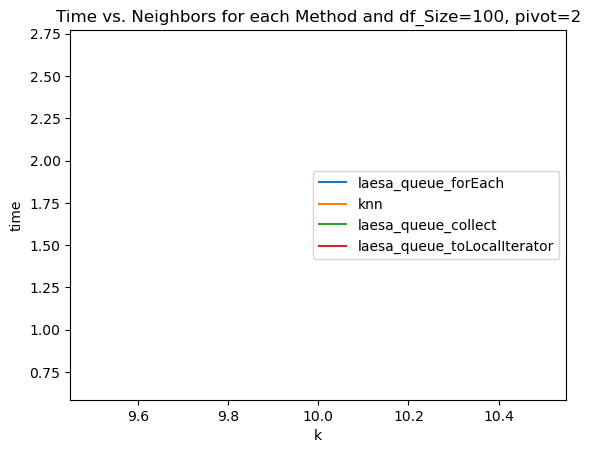

In [7]:

## 
## BENCHMARK
##

def benchmark():
    
    ## defines query object and 
    oq = [np.random.rand(1)[0],np.random.rand(1)[0]]
    
    ## defines neighbrs amount
    list_k = [10]
    
    ## defines size of dataframe    
    list_dfSize = ["/home/weber/Documents/coordDF100.csv"]#,"/home/weber/Documents/coordDF1K.csv","/home/weber/Documents/coordDF10K.csv","/home/weber/Documents/coordDF100K.csv"]
                  
    # define pivots amount
    list_pivot = [2]
      
     
    # create a list to save the results
    resultList = []
    # iterative index "id"
    j = 1
    
    
    # for each dataframe
    for df_size in list_dfSize:
        
        schema = StructType([
            StructField("id", IntegerType(), True),
            StructField("coord_x", FloatType(), True),
            StructField("coord_y", FloatType(), True)])
        
        df = spark.read.csv(df_size ,schema=schema)        
        size = df.count()
        ##SMALL SANITY CHECK - @PRODUCTION TESTAR LOADING
        df = df.na.drop()
        
        ## define the struct for the dimensional feature vector
        cNames = df.columns
        cNames.remove("id")
        assembler = VectorAssembler(
            inputCols=cNames,
            outputCol="fv")
        
        ## appends the fv into the dataframe as column
        df = assembler.transform(df)
        lista = []
        length_df = df.count()
        
        # for each k on the list of neighbors amount
        for k in list_k:
            
            # for each pivots amount
            for pivots in list_pivot:
                
                lista_columns = []
                
                # creates random pivots
                pivots_list = [(i+1,[np.random.rand(1)[0],np.random.rand(1)[0]]) for i in range(pivots)]
                
                ## calculates the distance from oi to pivots
                for i in range(len(pivots_list)):
                    df = df.withColumn(f'distances_oi_pivot{i+1}', simpleF(pivots_list[i][1])(F.col('fv')))
                    
                    
                for i in range(len(pivots_list)):
                    df = df.withColumn(f"|d(oq,p{i+1})-d(oi,p{i+1})|", \
                        abs (distance.euclidean(oq, pivots_list[i][1]) - \
                        F.col(f'distances_oi_pivot{i+1}')))

                    lista_columns.append(f"|d(oq,p{i+1})-d(oi,p{i+1})|")

                df = df.withColumn("lower_bound", greatest(*[col_name for col_name in lista_columns]))
                df = df.orderBy(df["lower_bound"])
            
                
                
                # measure the execution time of the laesa function
                start_time_knn = time.time()
                result3 = knn(df, oq, k)
                end_time_knn = time.time()  

                # save results in a tuple
                tuple = ()
                tuple += (j,"knn", size, k, pivots, end_time_knn - start_time_knn, 0)
            
                # save results tuple in a List            
                resultList.append(tuple)
                j+=1 
                
                
                # measure the execution time of the laesa function
                start_time_queue4 = time.time()
                result4 = laesa_queue(df, oq, k)
                end_time_queue4 = time.time()  

                # save results in a tuple
                tuple = ()
                tuple += (j,"laesa_queue_collect", size, k, pivots, end_time_queue4 - start_time_queue4, result4[1])
            
                # save results tuple in a List            
                resultList.append(tuple)
                j+=1 
                
                # measure the execution time of the laesa function
                start_time_queue5 = time.time()
                result5 = laesa_queue5(df, oq, k)
                end_time_queue5 = time.time()  
                
                print(result5[0])
                # save results in a tuple
                tuple = ()
                tuple += (j,"laesa_queue_forEach", size, k, pivots, end_time_queue5 - start_time_queue5, result5[1])
            
                # save results tuple in a List            
                resultList.append(tuple)
                j+=1 
                
                # measure the execution time of the laesa function
                start_time_queue6 = time.time()
                result6 = laesa_queue3(df, oq, k)
                end_time_queue6 = time.time()  

                # save results in a tuple
                tuple = ()
                tuple += (j,"laesa_queue_toLocalIterator", size, k, pivots, end_time_queue6 - start_time_queue6, result6[1])
            
                # save results tuple in a List            
                resultList.append(tuple)
                j+=1 
                
        
       
    # turn list of results into a dataframe        
    schema = StructType([
        StructField("id", IntegerType(), True),
        StructField("method", StringType(), True),
        StructField("df_size", IntegerType(), True),
        StructField("k", IntegerType(), True),
        StructField("pivots", IntegerType(), True),
        StructField("time", FloatType(), True),
        StructField("droped_rows", IntegerType(), True)])
    
    df_final = spark.createDataFrame(data = resultList, schema=schema)
    
    df_final.show()
    
    #df_final.write.csv("/home/weber/Documents/result.csv")
    
    unique_values = df_final.select("df_size").distinct().collect()
    k_values = [row[0] for row in unique_values]
    
    for k in k_values:
        df_df = df_final.filter(df_final["df_size"] == k)
        
        unique_values2 = df_df.select("pivots").distinct().collect()
        p_values = [row[0] for row in unique_values2]

        for p in p_values:
            
            df_df2 = df_df.filter(df_final["pivots"] == p)

            collect_df = df_df2.collect()

            lista_collect =[(row.method, row.k, row.time) for row in collect_df]

            # Assume that `data` is the list of tuples
            methods = set([d[0] for d in lista_collect])

            fig, ax = plt.subplots()

            for method in methods:
                x_vals = [d[1] for d in lista_collect if d[0] == method]
                y_vals = [d[2] for d in lista_collect if d[0] == method]
                ax.plot(x_vals, y_vals, label=method)

            ax.legend()
            ax.set_xlabel("k")
            ax.set_ylabel("time")
            ax.set_title(f"Time vs. Neighbors for each Method and df_Size={k}, pivot={p}")

            #plt.show()

    
    return(df_final, lista)
            
# CALLING BENCHMARK
lista = benchmark()[1]
#df = benchmark()[2]
